# What is the variance in that metric?

### Learn the utility of business metric probability distributions and how calculate them in Python

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Analysts often look at trends over time to get a feel for the level of noise in a metric, but too often noise in the measurement is not represented in the data that is used to make decisions.  Statements that get repeated and passed up the chain are things like "We are down 20% YoY."  Down 20% could be really bad, or if the metric is noisy it could just be something that happens. Of course experience will teach people if this is a metric that is really out of the normal when it is down 20%, but experience is not always unbiased and heard. Most business metrics are in the form of ratios. In this article I will explore how we can estimate the confidence of standard business metrics.

## Case

A team member says "Our transfer rate is 4%. This is down from the 5% that we usually see. That is a 20% decrease in the transfer rate! Something must be broken! We all need to stop what we are doing and investigate."  

You say "Let's take a closer look at the numbers before we pull numerous people off of important projects to investigate this. How many transfers have you had after something broke? How many attempts after something broke? How many transfers for the "working" system before it broke? How many attempts before?"
Your colleague finds the following numbers in their spreadsheet.

In [3]:
old_transfers = 100
old_attempts = 2000
new_transfers = 8
new_attempts = 200

In [4]:
transfer_rate_old = old_transfers/old_attempts
transfer_rate_old

0.05

In [5]:
transfer_rate_new = new_transfers/new_attempts
transfer_rate_new

0.04

In [6]:
percent_improvement = (transfer_rate_new-transfer_rate_old)/transfer_rate_old*100
np.round(percent_improvement)

-20.0

Because many business metrics like this are fractions they can be modeled as a binomial distribution. This is great. I love binomial distributions because it feels like I get the variance for free. All I need to know is the number of trials and then there it is, the variance magically appears as np(1-p). But wait what are n and p? n is the number of trials or the denominator in the metric and the parameter p can be estimated as the business metric. In our case this is 0.05 for the old working system and 0.04 for the broken system.

We can plot the probability mass function for the transfer ratio of the broken system and the transfer ratio of the working system assuming they follow a binomial distribution. In this article I am not going to dig into the assumptions that are made. The intent is to demonstrate a simple way to estimate the noise in business metrics to make better inform decisions; if you are going to use this method, I encourage you to dig further into these topics to be sure that your data follows all the assumptions required to use this simple method. I find that bootstrapping (https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a great way to better understand how your data fits the models (possibly my next article).

<IPython.core.display.Javascript object>


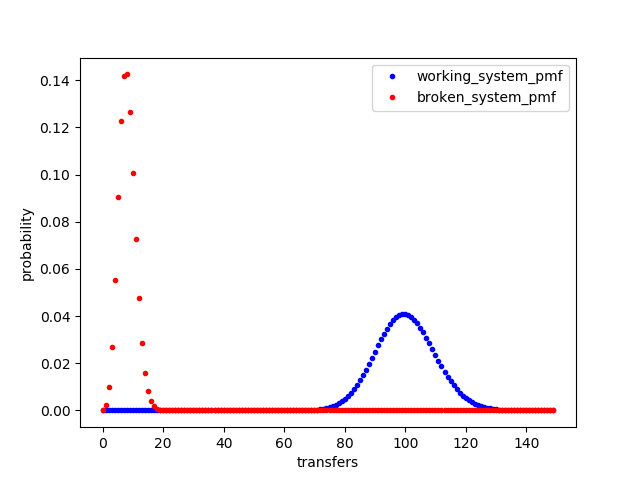

In [8]:
plot_max_x = 150
x_values = range(plot_max_x)
working_system_pmf = stats.binom.pmf(x_values, old_attempts, old_transfers/old_attempts)
plt.plot(x_values,working_system_pmf, 'b.', label = 'working_system_pmf')
broken_system_pmf = stats.binom.pmf(x_values, new_attempts, new_transfers/new_attempts)
plt.plot(x_values,broken_system_pmf, 'r.', label = 'broken_system_pmf')
plt.ylabel('probability')
plt.xlabel('transfers')
plt.legend()
plt.savefig('binomial_dist_plot.pdf')
plt.savefig('binomial_dist_plot.jpeg')

So, what am I looking at here in this plot? Well each customer either transfers or does not transfer. So there are a limited number of possibilities for any n attempts. If we only had three customers all the possible transfer values would be 0, 1, 2 or 3. The x values on this plot are the number of transfers and the y values are the probabilities for the broken system and the working system. This concept can be confusing. Don’t we know the transfers?  We do know the transfers measured. It was 8 for the broken system and 100 for the working system. But, this does not completely describe what we want to know. Our real interest is in the future transfer rate of the broken system and that is what is represented on this plot.  I find it helpful to think of our measurement as one attempt to measure the true value for the system. We measured 8 transfers for the broken system, but we know that every measurement contains noise. Maybe 10 transfers for every 200 attempts is the true transfer rate for the broken system? This plot shows to possible outcomes of a yet-to-be-performed measurement given the information that we have. As we collect more data we have a better estimate of the true rate for the system. But we can't wait. The system might be broken. We need to correctly interpret the data that we have now.

Obviously the working system is going to have more transfers, because we had so many more customers using this system. The curve for the working system looks fatter in this plot, which is usually associated with more noise. But this is deceptive. The highest transfers shown in the curve for the working system is about 125, which is not that much more than 100, the measured number of transfers, relative to the broken system that has highest part of the curve at about 17 with the measured number of transfers of only 8. So the relative variance is smaller in the working system because we made more measurements.

But, I still don't know what to do with this information. It does not seem that we are closer to comparing these ratios. Maybe we push forward with the investigation and forget the analysis?  We are actually much closer to understanding how confident we are that the system is broken than you might think thanks to the magic of the Bayes equation and conjugate priors.  

## posterior ∝ prior ⨉ likelihood

To keep things simple we will use a uniform distribution as a non-informative prior belief. Don't let this statement throw you off. It just means that we are going to avoid saying anything about what we believed the transfer rate was before we started collecting data for either of the two systems. Using the uniform distribution for our prior belief leads to a posterior distribution, the transfer rate that we are interested in, which is simply a beta distribution with alpha = 1+ transfers and beta = 1 + (attempts - transfers). Alpha and beta are the two parameters that are needed to describe a beta distribution. These are like the mean and standard deviation that are needed to describe the normal distribution.

The binomial distribution used to describe the number of successes in a sequence of n independent experiments. The beta distribution that we will use to describe the transfer rate is used to describe behavior of continuous variables like proportions which are defined on the interval between zero and one.

Bayes equation allows us to take the probability distribution of the data we collected using each system (figure 1) and transform it into an estimation of the probability of the metric (transfer rate). Again, this is an area that you should probably dig into to understand the assumptions that I made. Briefly, I assumed that I knew nothing of the transfer rate before collecting data on the two systems, and I took advantage of the fact that the total probability for all possible transfer rates for each system will be one. 

<IPython.core.display.Javascript object>


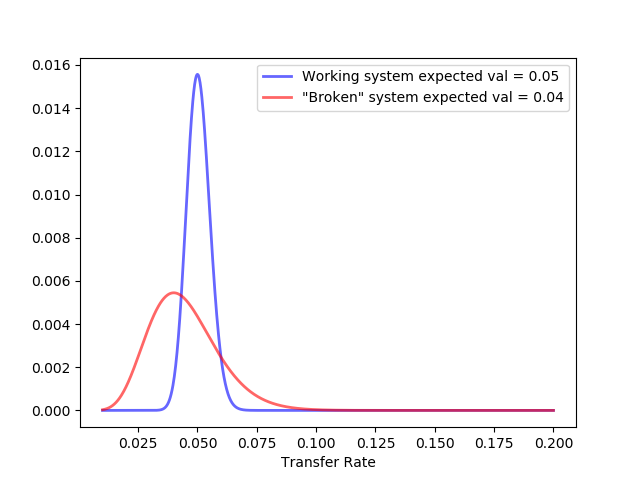

In [9]:
x = np.linspace(0.01, 0.2, 1000)
working_system_transfer_rate_pdf = stats.beta.pdf(x, old_transfers+1, (old_attempts-old_transfers)+1)/np.sum(stats.beta.pdf(x, old_transfers+1, (old_attempts-old_transfers)+1))
broken_system_transfer_rate_pdf = stats.beta.pdf(x, new_transfers+1, (new_attempts-new_transfers)+1)/np.sum(stats.beta.pdf(x, new_transfers+1, (new_attempts-new_transfers)+1))
# notice that I normalize the transfer rate by dividing each value by the total 
plt.plot(x, working_system_transfer_rate_pdf, 'b-', lw=2, alpha=0.6, label='Working system expected val = ' + str(np.round(old_transfers/old_attempts, 3)) )
plt.plot(x, broken_system_transfer_rate_pdf, 'r-', lw=2, alpha=0.6, label='"Broken" system expected val = ' + str(np.round(new_transfers/new_attempts, 3)) )
plt.legend()
plt.xlabel('Transfer Rate')
plt.savefig('beta_dist_plot.jpeg')

So what are we looking at here?  Well we know that each system has a transfer rate. The more measrements that we make the more accurate our estimate of the transfer rate becomes. We measured the transfer rate of the broken system to be 0.04, but if we were to measure this system for a few more days, we know that our estimate of the actual transfer rate would change some becasue there is noise in any measurement. This graph show an estimate of the probability distribution for the transfer rate of each system given the data that we currently have. This graph shows us that although the expected value for the transfer rate of the broken system is 0.04 there is a significant possibility that the broken system has a transfer rate of 0.05 or more. Given this graph, I would probably hold off on launching a large investigation, but we will have to combine this information with information about the cost of a lower transfer rate.  

## Conclusion

Graphs like the one above can help us to make more informed business decisions. With a little understanding of probability distributions and bayes equation and a few lines of code. We can draw probabilitiy distributions for the comparision of business metrics. The code for the article can be found here https://github.com/bprazen/business_metric_analysis.